In [1]:
from utils import *
from SolarFlareNet_test import *

Python version: 3.11.8
Tensorflow bakcend version: 2.14.0


In [2]:
Window = [24]
Class = ["M"]
feature_names = 'TOTUSJH,TOTUSJZ,USFLUX,MEANALP,R_VALUE,TOTPOT,SAVNCPP,AREA_ACR,ABSNJZH'.split(',')

In [3]:
from PIL import Image

def combine_images(columns, space, images, fname):
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1
    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0
    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width)/2)
        y_offset = int((height_max-img.height)/2)
        background.paste(img, (x+x_offset, y+y_offset))
        x += width_max + space
        if (i+1) % columns == 0:
            y += height_max + space
            x = 0
    background.save('%s' %fname)

In [4]:
# Create directories to save plots

def create_plot_dir(path):
    os.makedirs(path,  exist_ok=True)
    return

In [5]:
"""
#Train existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.
#You change the values to limit the flare types and number of hours to train.
print('Loading the train_model function...')
from SolarFlareNet_train import *
for time_window in Window:
    for flare_class in Class:
        train(str(time_window), flare_class)
        #log('===========================================================\n\n',verbose=True)
"""

"\n#Train existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.\n#You change the values to limit the flare types and number of hours to train.\nprint('Loading the train_model function...')\nfrom SolarFlareNet_train import *\nfor time_window in Window:\n    for flare_class in Class:\n        train(str(time_window), flare_class)\n        #log('===========================================================\n\n',verbose=True)\n"

Testing is initiated for time_window: 24 and flare class: M
loading data from file: data/training_data_M_24.csv
M --> Training: Positive: 11513 Negative: 147167
Adding Gaussian Noise
M --> With Noise Training: Positive: 23026 Negative: 147167
loading data from file: data/testing_data_M_24.csv
M --> Training: Positive: 1368 Negative: 46407
Loading transformer encoder blocks..
Loading weights from model dir: interpret_models/24/M
Predicting test data set samples..
Saving result to file: result/SolarFlareNet/M_24.csv
Training Dataset lenght: 170193
Testing Dataset lenght: 47775
Interpreting using SHAP method
   col_name  feature_importance_vals
5    TOTPOT                 0.069387
6   SAVNCPP                 0.063598
3   MEANALP                 0.043673
1   TOTUSJZ                 0.035096
4   R_VALUE                 0.027078
2    USFLUX                 0.027063
8   ABSNJZH                 0.019420
7  AREA_ACR                 0.014610
0   TOTUSJH                 0.014519


Interpreting using PDP method


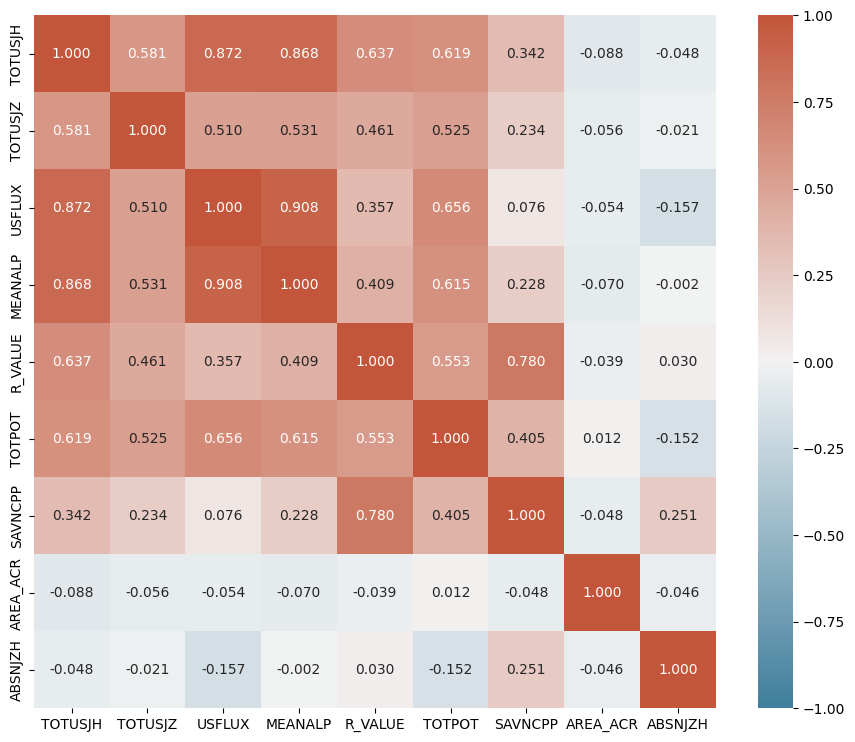

In [6]:
#Dependencies
#!pip install lime (to run LIME)
#!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython (to run ALE)
#!pip install alibi[ray] (to run ALE and PDP)
#!pip install shap (to run SHAP)

from lime.lime_tabular import RecurrentTabularExplainer
#from alibi.explainers import ALE, plot_ale
from alepython import ale_plot
import shap
from shap import DeepExplainer
import matplotlib.pyplot as plt
import seaborn as sb
#from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import PartialDependence, plot_pd
#from anchor import utils
from anchor import anchor_tabular
import random

#Test existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.
#You change the values to limit the flare types and number of hours to test.

# You change the tools listed in the interpretable_tools dict for using a specific tool to interpret
# LIME key takes a list of instances or a slice which consideres instances upto that range (i.e. example slice(1000)-> [:1000])
# ALE key takes a list containg types of plot we want. ["1D", "2D"]
# SHAP tool is not yet implemented.
# limit is the number of test cases considered to generate the results.

interpretable_tools = {"LIM":[[15, 6500], "slice(None)"], "AL":["1Dh", "2D"], "SHAP":None, "PDP":'al', "AN":3}
tool_fn = lambda x: print("Interpreting using %s method" %x)
train_limit = 1000
test_limit = 500
final_ranking = None
ranking = None

for time_window in Window:
    for flare_class in Class:
        model, train_data, test_data, pred_prob = test(str(time_window), flare_class)
        print("Training Dataset lenght: %d" %len(train_data[1]))
        print("Testing Dataset lenght: %d" %len(test_data[1]))
        random.seed(42)
        train_rows = random.sample([x for x in range(train_data[0].shape[0])], train_limit)
        test_rows = random.sample([x for x in range(test_data[0].shape[0])], test_limit)
        # Creating new train test samples for interpreting the model
        X_train, y_train, X_test, y_test, y_pred = train_data[0][train_rows], train_data[1][train_rows], test_data[0][test_rows], test_data[1][test_rows], pred_prob[test_rows]
        #model.summary()
        #log('===========================================================\n\n',verbose=True)

        X_df = pd.DataFrame(np.squeeze(np.vstack((train_data[0],test_data[0]))), columns=feature_names)
        corr = X_df.corr(method='pearson')
        sorted_corr = corr.replace(1.0, np.nan).unstack().dropna().sort_values(ascending=False, key=abs).drop_duplicates().to_dict()
        assert len(sorted_corr) == math.comb(len(feature_names),2)
        ranked_corr = list(sorted_corr.keys())

        for tool in interpretable_tools:
            if tool == "LIME":
                tool_fn(tool)
                model_mask = model.get_model()
                explainer = RecurrentTabularExplainer(X_train, training_labels=y_train, feature_names=feature_names,
                                                    discretize_continuous=True, verbose=False, feature_selection='none',
                                                    class_names=['Negative', 'Positive'], discretizer='decile')
                instances = interpretable_tools[tool]
                for instance in instances:
                    if isinstance(instance, list):
                        plt_dir = tool + os.sep + "%d_%s" %(time_window,flare_class)
                        path_fn = lambda x: plt_dir + os.sep + "%s" %x
                        create_plot_dir(plt_dir)
                        for i in instance:
                            exp = explainer.explain_instance(X_test[i], model_mask.predict, num_features=len(feature_names), num_samples=5000)
                            exp.show_in_notebook()
                            fig = exp.as_pyplot_figure()
                            fig.savefig(path_fn("%d_%s_%d.png" %(time_window, flare_class, i)))
                            exp.save_to_file(file_path=path_fn("%d_%s_%d.html" %(time_window, flare_class, i)))
                    elif isinstance(instance, slice):
                        feature_rank = {x:[] for x in feature_names}
                        for data in X_test[instance]:
                            exp = explainer.explain_instance(data, model_mask.predict, num_features=len(feature_names), num_samples=5000)
                            exp_map = exp.as_map()
                            for k, rank in enumerate(exp_map[1]):
                                feature_rank[feature_names[rank[0]]].append(k+1)
                        feature_rank = pd.DataFrame(feature_rank)
                        final_ranking = feature_rank.mean().sort_values()
                        ranking = final_ranking.to_dict()
            elif tool == "ALE":
                tool_fn(tool)
                plot_type = interpretable_tools[tool]
                for plt_type in plot_type:
                    plt_dir = tool + os.sep + plt_type + os.sep + "%d_%s" %(time_window, flare_class)
                    path_fn = lambda x: plt_dir + os.sep + "%s" %x
                    if plt_type == "1D":
                        create_plot_dir(plt_dir)
                        """
                        ale = ALE(model.predict, feature_names=feature_names, target_names=["Label"])
                        ale_exp = ale.explain(np.squeeze(X_train), min_bin_points=20)
                        ax_1d = plot_ale(ale_exp, n_cols=3, sharey=None, fig_kw={'figwidth':14, 'figheight': 10})
                        fig_1d = ax_1d[0][0].get_figure()
                        fig_1d.savefig(path_fn("%d_%s" %(time_window, flare_class)))
                        """
                        X_train_df = pd.DataFrame(np.squeeze(X_train), columns=feature_names)
                        figures = []
                        fig = plt.figure()
                        for i,f1 in enumerate(feature_names):
                            ax_1d = ale_plot(model, X_train_df, f1, bins=50, monte_carlo=True, monte_carlo_rep=50)
                            ax_1d.set_title(None)
                            ax_1d.set_xlabel(None)
                            fig_1d = ax_1d.get_figure()
                            fig_1d.savefig(path_fn("%s.pdf" %f1))
                            figures += [path_fn("%s.pdf" %f1)]
                            #fig.add_axes(ax_1d)    #WARNING exicuting this generates a ValueError: The Axes must have been created in the present figure
                        combine = False     #WARNING only set it to True if the generated images are in .png format and should be combined into a single image
                        if len(figures) == len(feature_names) and combine == True:
                            combine_images(3, 0, figures, path_fn("%d_%s.pdf" %(time_window, flare_class)))
                    elif plt_type == "2D":
                        create_plot_dir(plt_dir)
                        X_train_df = pd.DataFrame(np.squeeze(X_train), columns=feature_names)
                        mask = np.triu(np.ones_like(corr, dtype=bool), 1)
                        cmap = sb.diverging_palette(230, 20, as_cmap=True)
                        fig = plt.figure(figsize=(12,10))
                        ax = sb.heatmap(corr, vmin=-1, vmax=1, cmap=cmap, mask=mask, annot=True, fmt='.3f')
                        fig.savefig(path_fn("corr_heatmap.pdf"))
                        plt.show()
                        figures = []
                        plt.rc("figure", figsize=(9,6))
                        for i, f1 in enumerate(feature_names):
                            for f2 in feature_names[i:]:
                                if f1 != f2:
                                    #figures += [path_fn("%s_vs_%s.png" %(f1,f2))]
                                    if (f1 in ranked_corr[0] and f2 in ranked_corr[0]) or (f1 in ranked_corr[-1] and f2 in ranked_corr[-1]):
                                        ax_2d = ale_plot(model, X_train_df, [f1,f2], bins=50)
                                        print(f1, f2)
                                        ax_2d.set_title(None)
                                        ax_2d.set_xlabel(f1)
                                        ax_2d.set_ylabel(f2)
                                        fig_2d = ax_2d.get_figure()
                                        fig_2d.savefig(path_fn("%s_vs_%s.pdf" %(f1,f2)))
                        if len(figures) == math.comb(len(feature_names),2):
                            combine_images(6, 0, figures, path_fn("%d_%s.pdf" %(time_window, flare_class)))
            elif tool == "SHAP":
                tool_fn(tool)
                plt_dir = tool + os.sep + "%d_%s" %(time_window,flare_class)
                path_fn = lambda x: plt_dir + os.sep + "%s" %x
                create_plot_dir(plt_dir)
                model_mask = model.get_model()

                explainer = DeepExplainer(model_mask, X_train)
                expected_value = explainer.expected_value
                shap_values = explainer.shap_values(X_test, check_additivity=True)
                for i,shap_value in enumerate(shap_values):
                    shap_values[i] = np.squeeze(shap_value)
                
                vals = np.abs(shap_values[0]).mean(0)
                feature_importance = pd.DataFrame(list(zip(feature_names,vals)),columns=['col_name','feature_importance_vals'])
                feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
                feature_order = feature_importance['col_name'].values.tolist()
                feature_order_idx = feature_importance['col_name'].index.to_list()
                print(feature_importance)

                shap.initjs()
                shap.decision_plot(expected_value[0], shap_values[0], feature_names, show=False)
                plt.savefig(path_fn("%s_%s.pdf" %(tool,"decision")))
                plt.close()
                display(shap.force_plot(expected_value[0], shap_values[0], feature_names, matplotlib=False))
                display(shap.force_plot(expected_value[1], shap_values[1][0], feature_names, link='logit', matplotlib=False, show=True))
                plt.savefig(path_fn("%s_%s.pdf" %(tool,"force")))
                plt.close()
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
                ax_idx = 0
                for i,name in zip(feature_order_idx,feature_order):
                    if name == feature_order[0] or name == feature_order[-1]:
                        for pair in sorted_corr:
                            if name in pair:
                                pair_list = list(pair)
                                pair_list.remove(name)
                                break
                        shap.dependence_plot(i, shap_values[0], np.squeeze(X_test), feature_names, interaction_index=pair_list[0], ax=ax[ax_idx], show=False)
                        ax_idx += 1
                fig.savefig(path_fn("%s_%s.pdf" %(tool,"dependence")))
                plt.close()
                shap.summary_plot(shap_values, feature_names, show=False)
                plt.savefig(path_fn("%s_%s.pdf" %(tool,"summary_bar")))
                plt.close()
                shap.summary_plot(shap_values[0], np.squeeze(X_test), feature_names, show=False)
                plt.savefig(path_fn("%s_%s.pdf" %(tool,"summary_violin")))
                plt.close()
                from shap.plots._beeswarm import summary_legacy
                summary_legacy(shap_values[0], feature_names, plot_type="violin", show_values_in_legend=True, show=False)
                plt.savefig(path_fn("%s_%s.pdf" %(tool,"beeswarm_violin")))
                plt.close()
            elif tool == "PDP":
                tool_fn(tool)
                plt_dir = tool + os.sep + "%d_%s" %(time_window,flare_class)
                path_fn = lambda x: plt_dir + os.sep + "%s" %x
                create_plot_dir(plt_dir)
                
                if "SHAP" in interpretable_tools and interpretable_tools[tool] != 'all':
                    selected_features = [feature_order_idx[0], feature_order_idx[-1]]
                    dim = (4,10)
                else:
                    selected_features = 'all'
                    dim = (10,15)

                mask = np.triu(np.ones_like(corr, dtype=bool), 1)
                cmap = sb.diverging_palette(230, 20, as_cmap=True)
                fig = plt.figure(figsize=(11,9))
                ax = sb.heatmap(corr, vmin=-1, vmax=1, cmap=cmap, mask=None, annot=True, fmt='.3f')
                fig.savefig(path_fn("corr_heatmap.pdf"))
                plt.show()
                plt.close()

                explainer = PartialDependence(predictor=model.predict, feature_names=feature_names, target_names=["Probability"])
                exp = explainer.explain(X=np.squeeze(X_train), features=None, kind='average')
                axes = plot_pd(exp=exp, features=selected_features, n_cols=3, sharey='all', center=True, fig_kw={'figheight': dim[0], 'figwidth': dim[1]})
                fig = np.ndarray.flatten(axes).tolist()[0].get_figure()
                fig.savefig(path_fn("PDP.pdf"))
                plt.close()
                combinations = []
                for i, f1 in enumerate(feature_names):
                    for j, f2 in enumerate(feature_names[i:]):
                        if f1 != f2:
                            if (f1 in ranked_corr[0] and f2 in ranked_corr[0]) or (f1 in ranked_corr[-1] and f2 in ranked_corr[-1]):
                                combinations += [(i,i+j)]
                exp_2d = explainer.explain(X=np.squeeze(X_train), features=combinations, kind='average')
                axes_2d = plot_pd(exp=exp_2d, n_cols=2, sharey='all', center=True, fig_kw={'figheight': 4, 'figwidth': 10})
                fig = np.ndarray.flatten(axes_2d).tolist()[0].get_figure()
                fig.savefig(path_fn("PDP_2d.pdf"))
                plt.close()
            elif tool == "ANC":
                tool_fn(tool)
                plt_dir = tool + os.sep + "%d_%s" %(time_window,flare_class)
                path_fn = lambda x: plt_dir + os.sep + "%s" %x
                create_plot_dir(plt_dir)
                instance = interpretable_tools[tool]

                explainer = anchor_tabular.AnchorTabularExplainer(["Negative", "Positive"], feature_names=feature_names, train_data=np.squeeze(X_train), discretizer='decile')
                exp = explainer.explain_instance(np.squeeze(X_test)[instance], model.predict, threshold=0.95)
                print('Partial anchor: %s' % (' AND '.join(exp.names(1))))
                print('Partial precision: %.2f' % exp.precision(1))
                print('Partial coverage: %.2f' % exp.coverage(1))
                for name in exp.names():
                    print(name)
                exp.show_in_notebook()

In [7]:
print(final_ranking)
print(ranking)

None
None
